In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams,font_manager
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches
import matplotlib.colors as colors
import os

In [3]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [421]:
def load_data(direc,f):
    df = pd.read_csv(direc +f, header=None,
                     names=['idx','subject_id','color','eyecal_m','mi',
                            'status','bp','wp','m','rt','timestamp','a','b']).drop(columns=['idx','a','b','eyecal_m'])
    df = df[df['status']!='eyecal']
    df['subject_id'] = f.split('_')[1].split('.')[0]
    return df

direc = 'C:/Users/svo/Documents/FourinarowData/Raw Data/'

untrained_df = pd.concat([load_data(direc + 'Untrained/', f) for f in os.listdir(direc + 'Untrained/')]).reset_index(drop=True)
untrained_df['condition'] = 'novice'
untrained_df['subject_id'] = untrained_df['subject_id']+'_n'
trained_df = pd.concat([load_data(direc + 'Trained/', f) for f in os.listdir(direc + 'Trained/')]).reset_index(drop=True)
trained_df['condition'] = 'expert'
trained_df['subject_id'] = trained_df['subject_id']+'_e'

df = pd.concat([untrained_df,trained_df]).reset_index(drop=True)
board_df = pd.read_csv(direc + 'board_stat.txt',header=None,names=['bp','wp','is_real',],sep=' ')
board_id_dict = {board_id:i for i,board_id in enumerate(np.unique(board_df['bp']+board_df['wp']))}
is_real_dict = {board_id:is_real for board_id,is_real in zip(board_df['bp']+board_df['wp'],board_df['is_real'])}

df.loc[df['status']=='reconi','board_id'] = (df[df['status']=='reconi']['bp'] +df[df['status']=='reconi']['wp']).map(board_id_dict).astype(int)
df.loc[df['status']=='reconi','is_real'] = (df[df['status']=='reconi']['bp'] +df[df['status']=='reconi']['wp']).map(is_real_dict).astype(bool)

k = board_id_dict['000000000000001000000101000000111000011010000100100000000000000000000100']
df.loc[(df['status']=='reconi') & (df['board_id']>k),'board_id']+=1
for s in np.unique(df['subject_id']):
    df.loc[(df['subject_id']==s) & (df['status']=='reconi') & (df['board_id']==k),'board_id']=[k,k+1]
    
df['board_id'] = df['board_id'].fillna(method='ffill')
df['is_real'] = df['is_real'].fillna(method='ffill')

In [422]:
#{board_id_dict[board_id]:i for i,board_id in enumerate(np.unique((df[(df['status']=='reconi')]['bp']+df[(df['status']=='reconi')]['wp'])))}

In [423]:
df

,subject_id,color,mi,status,bp,wp,m,rt,timestamp,condition,board_id,is_real
0,AC_n,0,0,reconi,000011100001001010000101000000000010,000000010010010100000010110000001100,99,1199,1465931993998,novice,40.0,True
1,AC_n,0,0,recon,000010000000000000000000000000000000,000000000000000000000000000000000000,4,1199,1465931997713,novice,40.0,True
2,AC_n,0,1,recon,000011000000000000000000000000000000,000000000000000000000000000000000000,5,1199,1465931999311,novice,40.0,True
3,AC_n,0,2,recon,000011100000000000000000000000000000,000000000000000000000000000000000000,6,1199,1465932000143,novice,40.0,True
4,AC_n,0,3,recon,000011100000001000000000000000000000,000000000000000000000000000000000000,14,1199,1465932004023,novice,40.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
63351,YZ_e,1,14,recon,000101000010010100000000000010010100,000000000000000000001001000000000000,20,2235,1455917435879,expert,50.0,False
63352,YZ_e,1,15,recon,000101000010010100000000000010010100,000000000000000000001101000000000000,21,2235,1455917436270,expert,50.0,False
63353,YZ_e,1,16,recon,000101000010010100000000000010010100,000000000000000000001101000001000000,29,2235,1455917437518,expert,50.0,False
63354,YZ_e,1,17,recon,000101000010010100000000000010010100,000000000000000000001101000001100000,30,2235,1455917437927,expert,50.0,False


In [424]:
def get_accuracy(condition,is_real):
    
    original_bp = np.vstack(df[(df['status']=='reconi') & (df['condition']==condition) & (df['is_real']==is_real)]['bp'].apply(lambda s: [int(x) for x in s]))
    original_wp = np.vstack(df[(df['status']=='reconi') & (df['condition']==condition) & (df['is_real']==is_real)]['wp'].apply(lambda s: [int(x) for x in s]))
    reconstr_bp = np.vstack(df[(df['status']=='reconf') & (df['condition']==condition) & (df['is_real']==is_real)]['bp'].apply(lambda s: [int(x) for x in s]))
    reconstr_wp = np.vstack(df[(df['status']=='reconf') & (df['condition']==condition) & (df['is_real']==is_real)]['wp'].apply(lambda s: [int(x) for x in s]))
    original = original_bp - original_wp
    reconstructed = reconstr_bp - reconstr_wp
    return [[np.mean(reconstructed[original==i]==j) for i in [0,-1,1]] for j in [0,-1,1]]

[[0.9491534067727458, 0.20065789473684212, 0.19093567251461988], [0.02453080375356997, 0.7407581453634086, 0.062134502923976605], [0.02631578947368421, 0.05858395989974937, 0.7469298245614036]]


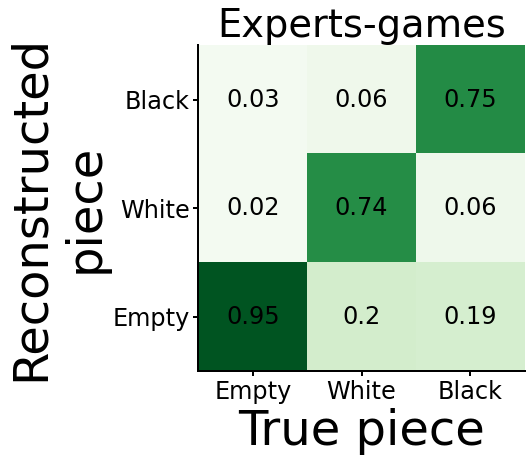

In [425]:
x = get_accuracy('expert',True)

print(x)

plt.imshow(x,cmap='Greens',vmin=0,vmax=1,origin='lower')
for i in [0,1,2]:
    for j in [0,1,2]:
        plt.text(x=j,y=i,s=x[i][j].round(2),ha='center',va='center',fontsize=24)
plt.xticks([0,1,2],['Empty','White','Black'])
plt.yticks([0,1,2],['Empty','White','Black'])
plt.xlabel('True piece',fontsize=48)
plt.ylabel('Reconstructed\npiece',fontsize=48)
plt.title('Experts-games')
plt.show()

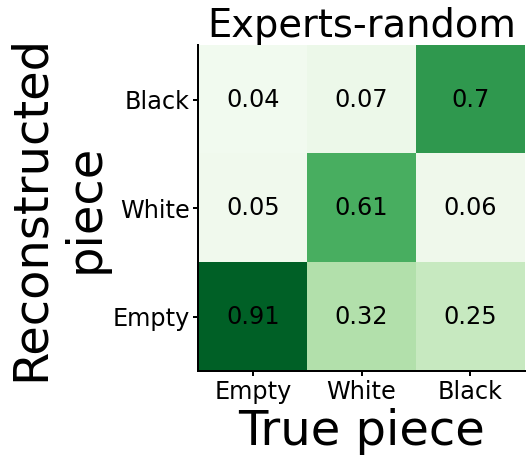

In [426]:
x = get_accuracy('expert',False)

plt.imshow(x,cmap='Greens',vmin=0,vmax=1,origin='lower')
for i in [0,1,2]:
    for j in [0,1,2]:
        plt.text(x=j,y=i,s=x[i][j].round(2),ha='center',va='center',fontsize=24)
plt.xticks([0,1,2],['Empty','White','Black'])
plt.yticks([0,1,2],['Empty','White','Black'])
plt.xlabel('True piece',fontsize=48)
plt.ylabel('Reconstructed\npiece',fontsize=48)
plt.title('Experts-random')
plt.show()

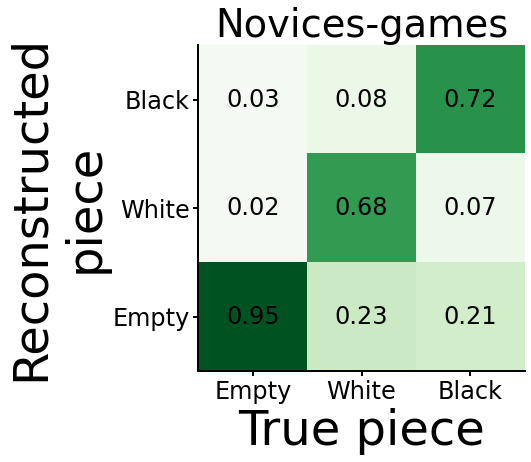

In [427]:
x = get_accuracy('novice',True)

plt.imshow(x,cmap='Greens',vmin=0,vmax=1,origin='lower')
for i in [0,1,2]:
    for j in [0,1,2]:
        plt.text(x=j,y=i,s=x[i][j].round(2),ha='center',va='center',fontsize=24)
plt.xticks([0,1,2],['Empty','White','Black'])
plt.yticks([0,1,2],['Empty','White','Black'])
plt.xlabel('True piece',fontsize=48)
plt.ylabel('Reconstructed\npiece',fontsize=48)
plt.title('Novices-games')
plt.show()

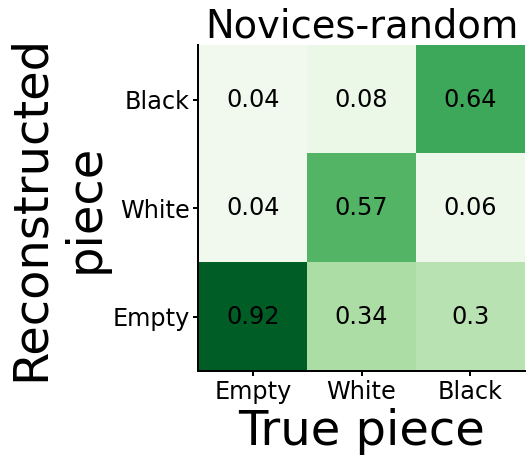

In [428]:
x = get_accuracy('novice',False)

plt.imshow(x,cmap='Greens',vmin=0,vmax=1,origin='lower')
for i in [0,1,2]:
    for j in [0,1,2]:
        plt.text(x=j,y=i,s=x[i][j].round(2),ha='center',va='center',fontsize=24)
plt.xticks([0,1,2],['Empty','White','Black'])
plt.yticks([0,1,2],['Empty','White','Black'])
plt.xlabel('True piece',fontsize=48)
plt.ylabel('Reconstructed\npiece',fontsize=48)
plt.title('Novices-random')
plt.show()

In [429]:
original_df = df[(df['status']=='reconi')].reset_index()

ind = original_df[(original_df['bp']=='000010000000100000000111000001000000') & (original_df['wp']=='001000000001010000001000100000000000')].index
df[(df['status']=='reconf')].reset_index().loc[ind]

,index,subject_id,color,mi,status,bp,wp,m,rt,timestamp,condition,board_id,is_real
6,141,AC_n,0,15,reconf,000010000000100000000110000001100000,001000000001010000001001000000000000,33,1199,1465932303088,novice,30.0,True
173,3360,AK_n,0,17,reconf,000010000000100000000111000000010000,001000000001010000001000100001000000,34,897,1490280379829,novice,30.0,True
247,4743,AN_n,0,19,reconf,000000100000100000000111100001000000,001001000001000000001000000000000000,31,810,1479748235469,novice,30.0,True
345,6511,CM_n,0,14,reconf,000010000000100000000111000001000000,001000000001010000001000100000000000,36,188,1476973360516,novice,30.0,True
400,7495,CP_n,1,22,reconf,001000000001000000001010000000000000,000000000000010000000101100000000000,28,604,1476119849982,novice,30.0,True
525,9472,EY_n,1,19,reconf,000010000000100000000100100001000000,001000000001001000001011000000000000,31,361,1490301379363,novice,30.0,True
587,10492,JE_n,1,12,reconf,000010000000100000000111000001000000,001000000001000000000000000000011000,31,625,1476731801491,novice,30.0,True
765,13298,KT_n,1,10,reconf,000010000000100000000111000001000000,001000000001000000000000100000000100,33,348,1476714095758,novice,30.0,True
777,13485,LH_n,1,11,reconf,000000000000010000000101100001000000,001000000001000000001010000000000000,31,711,1476296045884,novice,30.0,True
943,16606,MA_n,0,10,reconf,000000000000100000000111000001000000,001010000001000000001000100000000000,34,687,1476208179263,novice,30.0,True


In [430]:
def plot_board(status,board_id,condition):

    cm = colors.LinearSegmentedColormap.from_list('gray_gold_map', [colors.to_rgb('darkgray'), 
                                                                    colors.to_rgb('gold')], N=100)
    fig = plt.figure(figsize=[9,4])
    ax = fig.add_subplot(111,aspect='equal')
    ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5,color='black')
    ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5,color='black')

    bp = np.vstack(df[(df['status']==status) & (df['board_id']==board_id) & (df['condition']==condition)]['bp'].apply(
        lambda s: [int(x) for x in s])).mean(axis=0)
    wp = np.vstack(df[(df['status']==status) & (df['board_id']==board_id) & (df['condition']==condition)]['wp'].apply(
        lambda s: [int(x) for x in s])).mean(axis=0)

    for p in range(36):
        if bp[p]>0:
            w = patches.Wedge((p%9,p//9),0.33,90,360*bp[p]+90,color='black')
            w = ax.add_patch(w)
        if wp[p]>0:
            w = patches.Wedge((p%9,p//9),0.33,90-360*wp[p],90,color='white')
            w = ax.add_patch(w)
        if bp[p]>0 or wp[p]>0:
            circ = patches.Circle((p%9,p//9),0.33,color="black",fill=False)
            circ = ax.add_patch(circ)

    #for p in black_pieces:
    #    circ = patches.Circle((p%9,p//9),0.33,color="black",fill=True)
    #    circ = ax.add_patch(circ)
    #for p in white_pieces:
    #    circ = patches.Circle((p%9,p//9),0.33,color="white",fill=True)
    #    circ = ax.add_patch(circ)
    #for p in [response]:
    #    circ = patches.Circle((p%9,p//9),0.33,color=color,fill=False)
    #    circ = ax.add_patch(circ)
    plt.imshow(np.zeros(shape=[4,9]), cmap=cm, 
               interpolation='nearest',origin='lower',vmin=0,vmax=0.2)
    ax.axis('off')
    fig.tight_layout()
    plt.show()

In [440]:
boards_from_games = np.unique(df[df['is_real']]['board_id']).astype(int)
random_boards = np.unique(df[~df['is_real']]['board_id']).astype(int)

In [431]:
bp = np.vstack(df['bp'].apply(lambda s: [int(x) for x in s]))
wp = np.vstack(df['wp'].apply(lambda s: [int(x) for x in s]))


In [432]:
fourinarows = np.array([[ 0,  9, 18, 27], #hard-coding all ways in which four-in-a-row can appear
                       [ 1, 10, 19, 28],
                       [ 2, 11, 20, 29],
                       [ 3, 12, 21, 30],
                       [ 4, 13, 22, 31],
                       [ 5, 14, 23, 32],
                       [ 6, 15, 24, 33],
                       [ 7, 16, 25, 34],
                       [ 8, 17, 26, 35],
                       [ 0, 10, 20, 30],
                       [ 1, 11, 21, 31],
                       [ 2, 12, 22, 32],
                       [ 3, 13, 23, 33],
                       [ 4, 14, 24, 34],
                       [ 5, 15, 25, 35],
                       [ 3, 11, 19, 27],
                       [ 4, 12, 20, 28],
                       [ 5, 13, 21, 29],
                       [ 6, 14, 22, 30],
                       [ 7, 15, 23, 31],
                       [ 8, 16, 24, 32],
                       [ 0,  1,  2,  3],
                       [ 1,  2,  3,  4],
                       [ 2,  3,  4,  5],
                       [ 3,  4,  5,  6],
                       [ 4,  5,  6,  7],
                       [ 5,  6,  7,  8],
                       [ 9, 10, 11, 12],
                       [10, 11, 12, 13],
                       [11, 12, 13, 14],
                       [12, 13, 14, 15],
                       [13, 14, 15, 16],
                       [14, 15, 16, 17],
                       [18, 19, 20, 21],
                       [19, 20, 21, 22],
                       [20, 21, 22, 23],
                       [21, 22, 23, 24],
                       [22, 23, 24, 25],
                       [23, 24, 25, 26],
                       [27, 28, 29, 30],
                       [28, 29, 30, 31],
                       [29, 30, 31, 32],
                       [30, 31, 32, 33],
                       [31, 32, 33, 34],
                       [32, 33, 34, 35]],dtype=int)

In [433]:
threeinarows = np.vstack([fourinarows,fourinarows[:,[0,2,3,1]],fourinarows[:,[0,1,3,2]],fourinarows[:,[1,2,3,0]]])
twoinarows_conn = np.vstack([fourinarows,fourinarows[:,[1,2,0,3]],fourinarows[:,[2,3,0,1]]])
twoinarows_unc = np.vstack([fourinarows[:,[1,3,0,2]],fourinarows[:,[0,2,1,3]],fourinarows[:,[0,3,1,2]]])

In [434]:
black_3inarows = np.logical_and(np.sum(bp[:,threeinarows[:,:3]],axis=2)==3,np.sum(wp[:,threeinarows[:,3:]],axis=2)==0)
white_3inarows =  np.logical_and(np.sum(wp[:,threeinarows[:,:3]],axis=2)==3,np.sum(bp[:,threeinarows[:,3:]],axis=2)==0)
black_twoinarows_conn = np.logical_and(np.sum(bp[:,twoinarows_conn[:,:2]],axis=2)==2,np.sum(wp[:,twoinarows_conn[:,2:]],axis=2)==0)
white_twoinarows_conn =  np.logical_and(np.sum(wp[:,twoinarows_conn[:,:2]],axis=2)==2,np.sum(bp[:,twoinarows_conn[:,2:]],axis=2)==0)
black_twoinarows_unc = np.logical_and(np.sum(bp[:,twoinarows_unc[:,:2]],axis=2)==2,np.sum(wp[:,twoinarows_unc[:,2:]],axis=2)==0)
white_twoinarows_unc =  np.logical_and(np.sum(wp[:,twoinarows_unc[:,:2]],axis=2)==2,np.sum(bp[:,twoinarows_unc[:,2:]],axis=2)==0)

In [543]:
import warnings

#f = [black_twoinarows_unc,white_twoinarows_unc]
#f = [black_twoinarows_conn,white_twoinarows_conn]
f = [black_3inarows,white_3inarows]
with warnings.catch_warnings():
    fblack,fwhite = f
    warnings.simplefilter("ignore", category=RuntimeWarning)
    original_black = np.vstack([np.mean(fblack[(df['status']=='reconi') & (df['board_id']==n)],axis=0) 
                                for n in range(96)])
    original_white = np.vstack([np.mean(fwhite[(df['status']=='reconi') & (df['board_id']==n)],axis=0) 
                                for n in range(96)])
    reconstructed_expert_black = np.vstack([np.mean(fblack[(df['status']=='reconf') & (df['board_id']==n) & (df['condition']=='expert')],axis=0) 
                                 for n in range(96)])
    reconstructed_novice_black = np.vstack([np.mean(fblack[(df['status']=='reconf') & (df['board_id']==n) & (df['condition']=='novice')],axis=0) 
                                 for n in range(96)])
    reconstructed_expert_white = np.vstack([np.mean(fwhite[(df['status']=='reconf') & (df['board_id']==n) & (df['condition']=='expert')],axis=0) 
                                 for n in range(96)])
    reconstructed_novice_white= np.vstack([np.mean(fwhite[(df['status']=='reconf') & (df['board_id']==n) & (df['condition']=='novice')],axis=0) 
                                 for n in range(96)])


In [548]:
fblack

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [611]:
def get_first_reconstruction_time(f,n,s):
    t = np.hstack([(df[(df['status']=='recon') & (df['board_id']==n) & (df['subject_id']==s)]['timestamp'] - 
         np.mean(df[(df['status']=='reconi') & (df['board_id']==n) & (df['subject_id']==s)]['timestamp']))/1000,[np.nan]])
    first_ind = np.argmax(np.vstack([f[(df['status']=='recon') & (df['board_id']==n) & (df['subject_id']==s)],
                                     np.full([1,180],fill_value=True)]),axis=0)
    return t[first_ind]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    first_reconstruction_time_black = np.array([[get_first_reconstruction_time(fblack,n,s)
                                                  for n in range(96)] for s in df['subject_id'].unique()])
    first_reconstruction_time_white = np.array([[get_first_reconstruction_time(fwhite,n,s) 
                                                  for n in range(96)] for s in df['subject_id'].unique()])

#reconstructed_novice_black = np.vstack([[np.argmax(fblack[(df['status']=='recon') & (df['board_id']==n) & (df['subject_id']==s)],axis=0) 
#                             for n in range(96)] for s in df['subject_id'].unique()])


In [613]:
first_reconstruction_time  = np.nanmean(np.hstack([first_reconstruction_time_black,first_reconstruction_time_white]),axis=1)

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


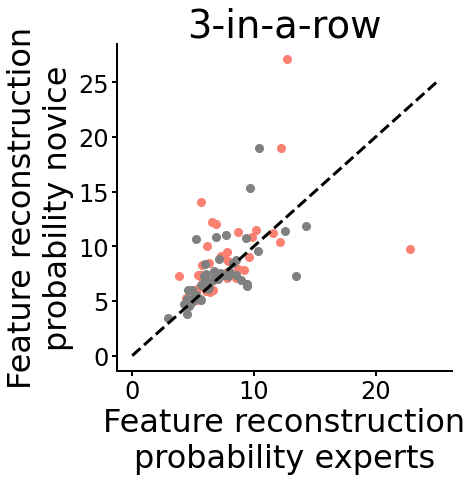

In [616]:
x = np.nanmean(first_reconstruction_time[:19,:],axis=0)
y = np.nanmean(first_reconstruction_time[19:,:],axis=0)

plt.plot(x[boards_from_games],y[boards_from_games],'.',color='salmon')
plt.plot(x[random_boards],y[random_boards],'.',color='gray')
plt.plot([0,25],[0,25],linestyle='dashed',color='black')
plt.xlabel('Feature reconstruction\nprobability experts')
plt.ylabel('Feature reconstruction\nprobability novice')
plt.title('3-in-a-row')
plt.show()    

In [578]:
reconstructed_expert_black

array([[0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [519]:
reconstructed_expert_black.shape

(96, 135)

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


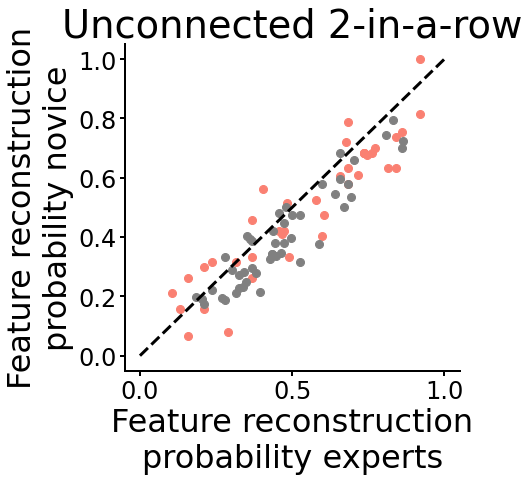

In [478]:
x = ((np.sum(reconstructed_expert_black*original_black,axis=1) +
          np.sum(reconstructed_expert_white*original_white,axis=1))/
         np.sum(original_black+original_white,axis=1))
y = ((np.sum(reconstructed_novice_black*original_black,axis=1) +
          np.sum(reconstructed_novice_white*original_white,axis=1))/
         np.sum(original_black+original_white,axis=1))

plt.plot(x[boards_from_games],y[boards_from_games],'.',color='salmon')
plt.plot(x[random_boards],y[random_boards],'.',color='gray')
plt.plot([0,1],[0,1],linestyle='dashed',color='black')
plt.xlabel('Feature reconstruction\nprobability experts')
plt.ylabel('Feature reconstruction\nprobability novice')
plt.title('Unconnected 2-in-a-row')
plt.show()    

96

In [507]:
rt_expert = [np.mean(df[(df['status']=='reconf') & (df['board_id']==n) & (df['condition']=='expert')]['timestamp'].values-
         df[(df['status']=='reconi') & (df['board_id']==n) & (df['condition']=='expert')]['timestamp'].values)/1000 for n in range(96)]

rt_novice = [np.mean(df[(df['status']=='reconf') & (df['board_id']==n) & (df['condition']=='novice')]['timestamp'].values-
         df[(df['status']=='reconi') & (df['board_id']==n) & (df['condition']=='novice')]['timestamp'].values)/1000 for n in range(96)]

In [508]:
rt_novice

[10.171368421052632,
 9.062052631578947,
 9.78442105263158,
 8.941578947368422,
 9.23378947368421,
 22.117947368421053,
 11.82021052631579,
 9.675263157894737,
 13.651894736842104,
 9.187315789473685,
 10.286421052631578,
 12.460473684210527,
 10.092894736842105,
 9.117315789473684,
 12.861526315789474,
 9.496,
 10.289157894736842,
 16.877736842105264,
 11.007315789473685,
 10.905421052631578,
 11.761105263157894,
 18.68621052631579,
 14.811105263157895,
 11.707736842105263,
 14.005631578947368,
 14.567263157894736,
 11.079684210526315,
 12.397263157894736,
 11.86121052631579,
 16.056526315789473,
 9.61478947368421,
 13.854947368421053,
 14.674526315789473,
 14.037,
 11.097315789473685,
 13.088263157894737,
 13.001263157894737,
 12.069684210526315,
 13.032578947368421,
 12.544105263157896,
 16.949157894736842,
 11.052052631578947,
 12.799315789473685,
 11.81321052631579,
 11.481684210526314,
 8.90321052631579,
 10.929578947368421,
 13.598421052631577,
 11.368578947368421,
 13.892526315

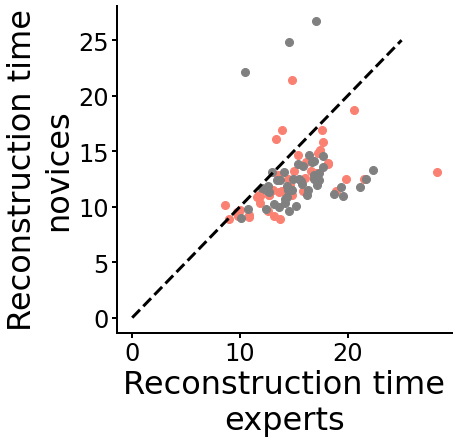

In [516]:
x = np.array(rt_expert)
y = np.array(rt_novice)

plt.plot(x[boards_from_games],y[boards_from_games],'.',color='salmon')
plt.plot(x[random_boards],y[random_boards],'.',color='gray')
plt.plot([0,25],[0,25],linestyle='dashed',color='black')
plt.xlabel('Reconstruction time\nexperts')
plt.ylabel('Reconstruction time\nnovices')
plt.show()    

In [620]:
np.mean(rt_expert)

15.106140350877192

In [461]:
df

,subject_id,color,mi,status,bp,wp,m,rt,timestamp,condition,board_id,is_real
0,AC_n,0,0,reconi,000011100001001010000101000000000010,000000010010010100000010110000001100,99,1199,1465931993998,novice,40.0,True
1,AC_n,0,0,recon,000010000000000000000000000000000000,000000000000000000000000000000000000,4,1199,1465931997713,novice,40.0,True
2,AC_n,0,1,recon,000011000000000000000000000000000000,000000000000000000000000000000000000,5,1199,1465931999311,novice,40.0,True
3,AC_n,0,2,recon,000011100000000000000000000000000000,000000000000000000000000000000000000,6,1199,1465932000143,novice,40.0,True
4,AC_n,0,3,recon,000011100000001000000000000000000000,000000000000000000000000000000000000,14,1199,1465932004023,novice,40.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
63351,YZ_e,1,14,recon,000101000010010100000000000010010100,000000000000000000001001000000000000,20,2235,1455917435879,expert,50.0,False
63352,YZ_e,1,15,recon,000101000010010100000000000010010100,000000000000000000001101000000000000,21,2235,1455917436270,expert,50.0,False
63353,YZ_e,1,16,recon,000101000010010100000000000010010100,000000000000000000001101000001000000,29,2235,1455917437518,expert,50.0,False
63354,YZ_e,1,17,recon,000101000010010100000000000010010100,000000000000000000001101000001100000,30,2235,1455917437927,expert,50.0,False


In [462]:
x = ((np.sum(reconstructed_expert_black*originial_black,axis=1) +
          np.sum(reconstructed_expert_white*originial_white,axis=1))/
         np.sum(originial_black+originial_white,axis=1) - 
         (np.sum(reconstructed_novice_black*originial_black,axis=1) +
          np.sum(reconstructed_novice_white*originial_white,axis=1))/
         np.sum(originial_black+originial_white,axis=1))

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [463]:
x

array([-0.07894737,  0.10526316,  0.14035088,  0.06432749,  0.10526316,
        0.15789474,  0.21052632,  0.10526316,  0.04453441, -0.04385965,
       -0.01315789,  0.10526316, -0.02631579,  0.21052632, -0.0877193 ,
        0.05263158,  0.18421053, -0.10526316,  0.05263158, -0.05263158,
               nan,  0.05263158,  0.        ,  0.09210526,         nan,
        0.07236842,  0.15789474,  0.10526316,  0.11695906,  0.05847953,
               nan,  0.10526316,  0.01315789,  0.09356725,  0.09210526,
        0.02631579,  0.11184211,  0.17894737,  0.21052632,  0.07894737,
       -0.10526316,         nan,         nan, -0.02339181,  0.03508772,
        0.10526316,  0.07017544,  0.09649123,         nan,  0.05263158,
        0.1       , -0.03157895,  0.09649123,  0.19298246, -0.02631579,
       -0.07894737,  0.07017544, -0.01754386,  0.17105263,  0.09473684,
       -0.02631579,  0.10526316,         nan,  0.03508772,  0.06390977,
       -0.0877193 ,  0.01578947, -0.10526316,         nan,  0.05

In [464]:
np.argsort(-x)[:5]

array([76, 38, 13,  6, 53], dtype=int64)

In [465]:
df['board_id'].min()

0.0

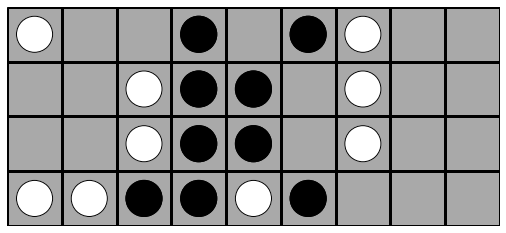

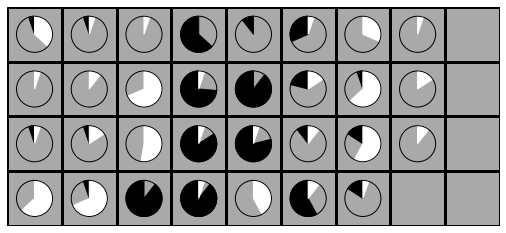

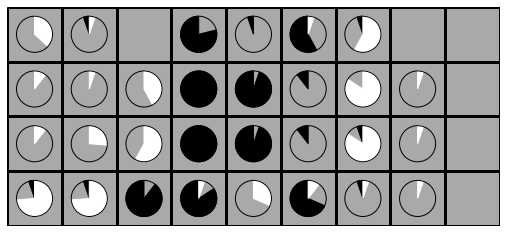

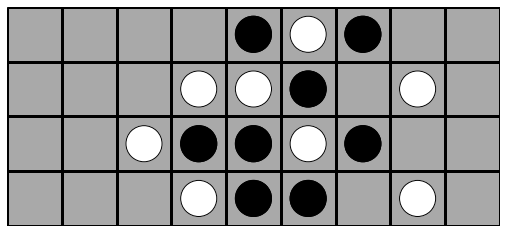

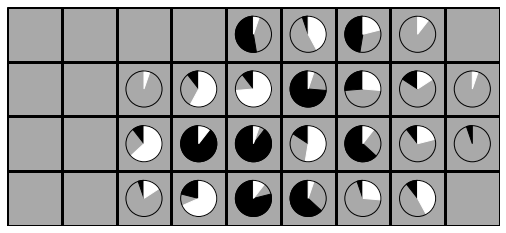

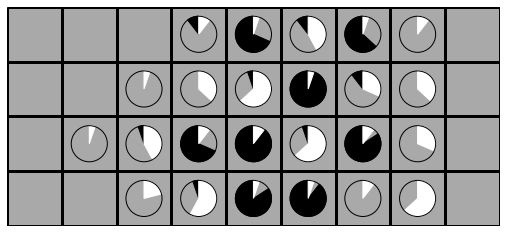

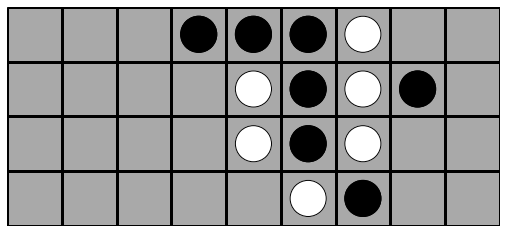

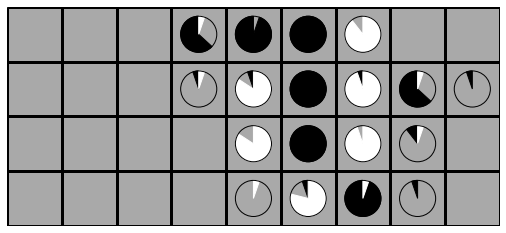

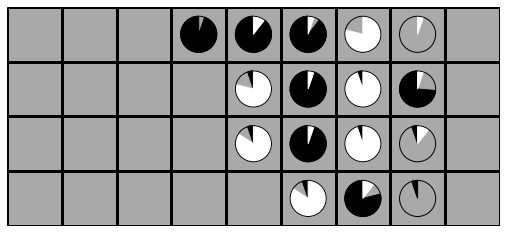

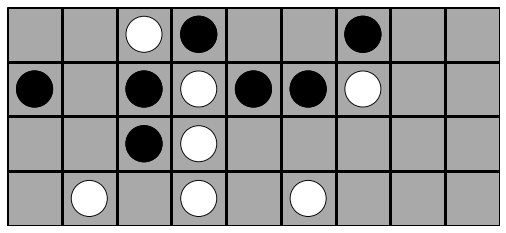

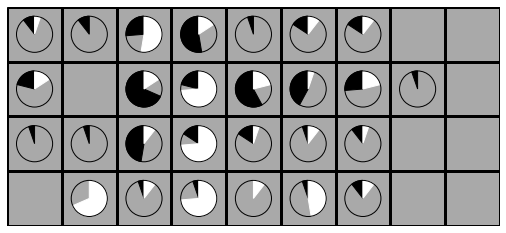

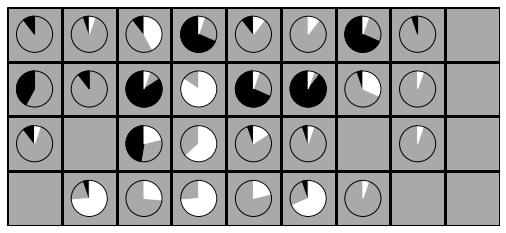

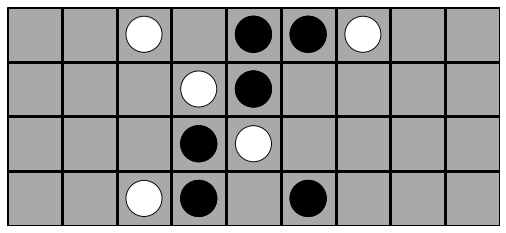

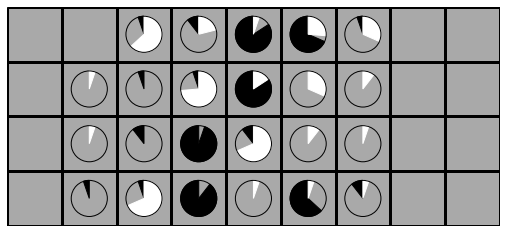

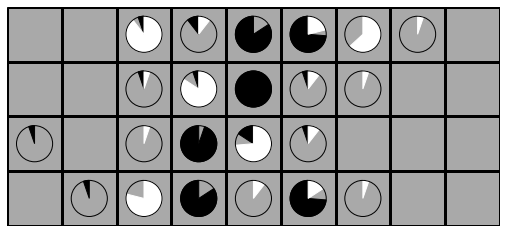

In [466]:
for board_id in np.argsort(-x)[:5]:
    plot_board('reconi',board_id,'expert')
    plot_board('reconf',board_id,'novice')
    plot_board('reconf',board_id,'expert')


In [190]:
df['status']

0        reconi
1         recon
2         recon
3         recon
4         recon
          ...  
63351     recon
63352     recon
63353     recon
63354     recon
63355    reconf
Name: status, Length: 63356, dtype: object